In [9]:
import statsmodels.api as sm
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
#import category_encoder as ce
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report

In [10]:
df = df = pd.read_csv("./cleaned_project_data.csv")

In [11]:
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hopital,payer_code,medical_specialty,num_lab_procedures,...,number_outpatient,number_emergency,number_inpatient,number_diagnoses,A1Cresult,metformin,insulin,change,diabetesMed,readmitted
0,Caucasian,Female,70-80,1,22,7,7,MC,Orthopedics-Reconstructive,58,...,0,0,0,9,None,No,Steady,1,1,0
1,Caucasian,Female,60-70,2,1,1,3,MC,Nephrology,59,...,0,0,0,6,None,No,Steady,0,1,0
2,Caucasian,Female,90-100,1,1,7,4,MC,Emergency/Trauma,56,...,0,0,0,6,None,No,No,0,1,0
3,Caucasian,Male,70-80,1,2,7,10,MC,InternalMedicine,68,...,0,0,0,6,None,Steady,Steady,1,1,0
4,Caucasian,Female,70-80,1,3,6,12,UN,InternalMedicine,77,...,0,0,0,5,8,No,Steady,0,1,0


In [12]:
df = df.drop(["age","diabetesMed","number_emergency","change","metformin","admission_type_id"
              ,"payer_code","number_inpatient","admission_source_id","A1Cresult","medical_specialty",
              "number_diagnoses","time_in_hopital","num_medications","num_procedures"], axis = 1)

In [13]:
df.head()

,race,gender,discharge_disposition_id,num_lab_procedures,number_outpatient,insulin,readmitted
0,Caucasian,Female,22,58,0,Steady,0
1,Caucasian,Female,1,59,0,Steady,0
2,Caucasian,Female,1,56,0,No,0
3,Caucasian,Male,2,68,0,Steady,0
4,Caucasian,Female,3,77,0,Steady,0


In [14]:
df.isnull().sum()

race                        0
gender                      0
discharge_disposition_id    0
num_lab_procedures          0
number_outpatient           0
insulin                     0
readmitted                  0
dtype: int64

In [15]:
df["readmitted"].value_counts()

0    15434
1    11706
Name: readmitted, dtype: int64

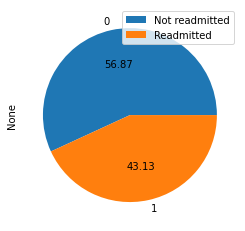

In [16]:
df.groupby("readmitted").size().plot(kind ="pie", autopct = "%.2f")
labels = ["Not readmitted", "Readmitted"]
plt.legend(labels)

df = pd.get_dummies(df,columns = ['age','insulin',
 'A1Cresult',
 'payer_code',
 'gender',
 'race',
 'medical_specialty',
 'metformin'])

In [17]:
encoder = LabelEncoder()
df["race"] = encoder.fit_transform(df["race"])
df["gender"] = encoder.fit_transform(df["gender"])
#df["payer_code"] = encoder.fit_transform(df["payer_code"])
#df["medical_specialty"] = encoder.fit_transform(df["medical_specialty"])
#df["A1Cresult"] = encoder.fit_transform(df["A1Cresult"])
#df["metformin"] = encoder.fit_transform(df["metformin"])
df["insulin"] = encoder.fit_transform(df["insulin"])
#df["age"] = encoder.fit_transform(df["age"])
df["readmitted"] = encoder.fit_transform(df["readmitted"])

#df["metformin"].unique()

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27140 entries, 0 to 27139
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   race                      27140 non-null  int64
 1   gender                    27140 non-null  int64
 2   discharge_disposition_id  27140 non-null  int64
 3   num_lab_procedures        27140 non-null  int64
 4   number_outpatient         27140 non-null  int64
 5   insulin                   27140 non-null  int64
 6   readmitted                27140 non-null  int64
dtypes: int64(7)
memory usage: 1.4 MB


In [19]:
df.head()

,race,gender,discharge_disposition_id,num_lab_procedures,number_outpatient,insulin,readmitted
0,2,0,22,58,0,2,0
1,2,0,1,59,0,2,0
2,2,0,1,56,0,1,0
3,2,1,2,68,0,2,0
4,2,0,3,77,0,2,0


In [20]:
df["readmitted"].value_counts()

0    15434
1    11706
Name: readmitted, dtype: int64

In [21]:
df.drop(df.columns)

KeyError: "['race' 'gender' 'discharge_disposition_id' 'num_lab_procedures'\n 'number_outpatient' 'insulin' 'readmitted'] not found in axis"

In [22]:
numerical_cols = ['discharge_disposition_id', 'num_lab_procedures','number_outpatient']
categorical_cols = list(set(df.columns) - set(numerical_cols)- {"readmitted"})

In [23]:
categorical_cols

['gender', 'insulin', 'race']

target = "readmitted"
y = df[target]
x = df.drop(columns = target)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=1066)

In [24]:
df_train, df_test = train_test_split(df,test_size = 0.2, random_state = 3)

In [25]:
len(df_train),len(df_test)

(21712, 5428)

In [26]:
scaler = StandardScaler()
def get_features_and_target_arrays(df,numerical_cols,categorical_cols,scaler):
    x_numeric_scaled = scaler.fit_transform(df[numerical_cols])
    x_categorical = df[categorical_cols].to_numpy()
    x = np.hstack((x_categorical, x_numeric_scaled))
    y = df["readmitted"]
    
    return(x,y)

In [27]:
x_train, y_train = get_features_and_target_arrays(df_train, numerical_cols, categorical_cols, scaler)
x_test, y_test = get_features_and_target_arrays(df_test, numerical_cols, categorical_cols, scaler)

In [28]:
svc_clf = SVC()
svc_clf.fit(x_train,y_train)
svc_pred = svc_clf.predict(x_test)
accuracy_score(y_test,svc_pred)

0.5921149594694178

In [29]:
#LogisticRegression
dtc = DecisionTreeClassifier()
dtc.fit(x_train,y_train)
dtc_pred = dtc.predict(x_test)
accuracy_score(y_test,dtc_pred)

0.5700073691967575

In [30]:
hlf = LogisticRegression()
hlf.fit(x_train,y_train)
hlf_pred = hlf.predict(x_test)
accuracy_score(y_test,hlf_pred)
print(classification_report(y_test,hlf_pred))

              precision    recall  f1-score   support

           0       0.58      0.95      0.72      3084
           1       0.57      0.08      0.14      2344

    accuracy                           0.58      5428
   macro avg       0.57      0.52      0.43      5428
weighted avg       0.57      0.58      0.47      5428



The accuracy score on logistic regression model is:  0.5766396462785557
The classification report on LR model is: 
               precision    recall  f1-score   support

           0       0.58      0.95      0.72      3084
           1       0.57      0.08      0.14      2344

    accuracy                           0.58      5428
   macro avg       0.57      0.52      0.43      5428
weighted avg       0.57      0.58      0.47      5428

The confusion matrix on LR model is: 
 [[2938  146]
 [2152  192]]


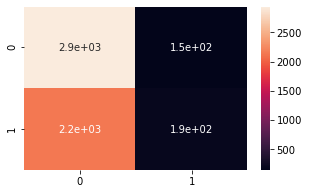

In [31]:
print("The accuracy score on logistic regression model is: ", accuracy_score(y_test,hlf_pred))
print ("The classification report on LR model is: \n",classification_report(y_test,hlf_pred))
cm = confusion_matrix(y_test,hlf_pred)
plt.figure(figsize=(5,3))
sns.heatmap(cm, annot = True)
print ("The confusion matrix on LR model is: \n",confusion_matrix(y_test,hlf_pred))

model = GradientBoostingClassifier(learning_rate=0.05, max_depth=5, n_estimators=500, min_samples_split=5, n_iter_no_change=10)
model.fit(x_train, y_train)



In [32]:
rmse =accuracy_score(y_test, model.predict(x_test))
rmse

NameError: name 'model' is not defined

Text(0.5, 1.0, 'Feature Importance')

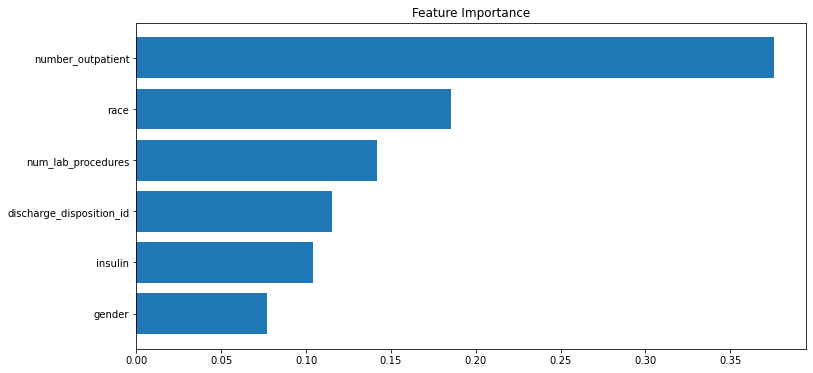

In [49]:
feature_importance = dtc.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(df_test.columns)[sorted_idx])
plt.title('Feature Importance')